# Course : big data and distributed systems

This notebook runned on a ECR instance using AWS for students.

### Dataset : 
Link to the data : https://www.kaggle.com/c/idc-big-data-platforms-2022-ml-competition/data

The dataset contains historical data about Uber rides in New York City. It can be loaded from here . The total size is about 1.5GB. The dataset has 7 columns for features (independent variables) + 1 column used for the label (dependent variable):
- Key - identifying each row in both the training and test sets. Unique integer. Required in your submission CSV. Not necessary in the training set, but could be useful to simulate a 'submission file' while doing cross-validation.
- Pickup_datetime is a timestamp value indicating when the Uber ride started.
- Pickup_longitude, Pickup_latitude, Dropoff_longitude, Dropoff_latitude - floats for longitude and latitude coordinates of where the Uber ride started and ended.
- Passenger_count - integer indicating the number of passengers.
- Fare ($) - float indicating the cost of the ride, used to create the label (class) for the classification model, or as the target for the regression model.


In this project we will preprocess the data and in order to build a classification machine learning model that tries to predict if the fare is lower or higher then $10. After training the model, given a set of (previously unseen) test data (w/o the fare) we want to predict (classify) for each row if the fare is < 10 or >= 10.


## 1 - Importing the data, setting spark and libraries 

In [1]:
import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession
from pyspark.context import SparkContext
from pyspark.sql.functions import *
from pyspark.sql.types import *
from datetime import date, timedelta, datetime
import time
import pyspark



VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
1,application_1645451490436_0002,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
# #Initialization of a Spark Session
# sc = SparkSession.builder.appName("PySparkExample")\
#     .config ("spark.sql.shuffle.partitions", "50") \
#     .config("spark.driver.maxResultSize","8g") \
#     .config ('spark.sql.execution.arrow.pyspark.enabled', "true")\
#     .getOrCreate()

In [2]:
from pyspark.sql import SparkSession, SQLContext
from pyspark import SparkConf, SparkContext
conf = SparkConf()
conf.set("spark.executor.memory", "12g")
conf.set("spark.driver.memory", "12g")
spark_context = SparkContext.getOrCreate(conf)
sc = SparkSession(spark_context)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
#Importing the data 

# path='idc-big-data-platforms-2022-ml-competition/idc_train.csv'
# data = sc.read.csv(path, inferSchema=True, header=True)

# path='s3://datakaggle/idc_train.csv'
# data = sc.read.csv(path, inferSchema=True, header=True)

path = 's3://datakaggle/cleen_data_2m.csv'
clean_data = sc.read.csv(path, inferSchema=True, header=True)



# testpath='idc-big-data-platforms-2022-ml-competition/idc_test.csv'
# test_set = sc.read.csv(testpath, inferSchema=True, header=True)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
#Cheking the type of each collumn 
data.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- key: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- pickup_datetime: string (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- passenger_count: integer (nullable = true)

## Data preparation

### In this part we will prepare the data, handle Na's values, outliers etc.

#### Data preparation stage will be done on all the 20 000 000 rows.

In [5]:
#Casting date from string to datetime 
from pyspark.sql import functions as F
from pyspark.sql.functions import to_timestamp

df = data.withColumn('pickup_date_time', F.to_timestamp(data.pickup_datetime)) #,'yyyy-MM-dd HH:mm:ss'))
df = df.drop('pickup_datetime') #remove the old column

In [14]:
#Checking the casting worked well. 
df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- key: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- pickup_date_time: timestamp (nullable = true)

In [15]:
#Showing the first 20 rows has been hashtagged for runtime purpose
# df.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---+-----------+----------------+---------------+-----------------+----------------+---------------+-------------------+
|key|fare_amount|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|   pickup_date_time|
+---+-----------+----------------+---------------+-----------------+----------------+---------------+-------------------+
|  1|        8.5|       -73.96539|      40.768574|       -73.998184|       40.761074|              1|2010-03-30 19:27:00|
|  2|      35.47|      -73.967354|      40.769295|       -73.967285|       40.802975|              1|2010-08-10 20:02:03|
|  3|        6.1|       -73.96884|      40.758278|       -73.961395|       40.768566|              1|2011-03-13 13:24:00|
|  4|        9.7|       -73.98218|      40.774796|        -73.95431|        40.78315|              1|2011-06-11 19:45:14|
|  5|        7.7|        -73.9778|       40.74228|       -73.998634|       40.734917|              1|2011-12-03 13:16:02|
+---+-----------+-------

In [6]:
#Creating a shape function for spark 
def sparkShape(dataFrame):
    return (dataFrame.count(), len(dataFrame.columns))
pyspark.sql.dataframe.DataFrame.shape = sparkShape


In [17]:
# #has been hashtagged for runtime purpose
# print('df shape',df.shape())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

df shape (19990000, 8)

In [7]:
#Function that is counting missing values in the differents columns
def count_missings(spark_df,sort=True):
    """
    Counts number of nulls and nans in each column
    """
    df = spark_df.select([F.count(F.when(F.isnan(c) | F.isnull(c), c)).alias(c) for (c,c_type) in spark_df.dtypes if c_type not in ('timestamp', 'string', 'date')]).toPandas()

    if len(df) == 0:
        print("There are no any missing values!")
        return None

    if sort:
        return df.rename(index={0: 'count'}).T.sort_values("count",ascending=False)

    return df

In [19]:
#Checking for Na's 

count_missings(df)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                   count
dropoff_longitude    137
dropoff_latitude     137
key                    0
fare_amount            0
pickup_longitude       0
pickup_latitude        0
passenger_count        0

#### Dropping the few Na's we have

In [8]:
#We have very few Nan so we decide to drop them
df1 = df.dropna(how='any')

In [21]:
#Checking that we have no Na's remaining  
count_missings(df1)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                   count
key                    0
fare_amount            0
pickup_longitude       0
pickup_latitude        0
dropoff_longitude      0
dropoff_latitude       0
passenger_count        0

In [22]:
# # Hashtagged for running time purpose
# df1.summary().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-----------------+-----------------+------------------+-----------------+------------------+-----------------+------------------+
|summary|              key|      fare_amount|  pickup_longitude|  pickup_latitude| dropoff_longitude| dropoff_latitude|   passenger_count|
+-------+-----------------+-----------------+------------------+-----------------+------------------+-----------------+------------------+
|  count|         19989863|         19989863|          19989863|         19989863|          19989863|         19989863|          19989863|
|   mean| 9994998.99157318|11.34476772151817|-72.51211170524284|39.92108885706621|-72.51080145697657|39.92031440227379| 1.685850873515241|
| stddev|5770618.023805641|16.91593038625327|12.916373088561272|9.690157381856485|12.773569810904812|9.683144129318139|1.3238763026418734|
|    min|                1|           -300.0|        -3414.1328|       -3478.2412|        -3442.0247|       -3547.8867|                 0|
|    25%|          4995598|

We can see sone anomlay, first we saw that we had trips with no passengers, and trips with 208 passengers. A uber is not supposed to have more than 10 (if we talk about a minivan) and so we want to remove all the trips that are not in the range 1 - 10.

We can observe that we have some extreme fare amounts : the maximun is 61 550 while the minimun is negative. We will remove all the fare amount that are not in the range 0 1000. Will 75% of the trips are aroung 12.5 it should not remove to much rows. 

In [9]:
#Filtering out all the trips which have weird passenger count
df2 = df1.filter(df1.passenger_count.between(1,10))

In [24]:
# #Number of rows removed, has been hashtagged for runtime purpose
# print('The number of rows removed because of passenger count is', df1.filter(df1.passenger_count.between(1,10)== False).count())


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

The number of rows removed because of passenger count is 70605

### Dealing with fare_amount column

In [10]:
#Now we are going to deal with fare_amount, starting a 2$ because under this trips are to shorts and to 200$ 
df2.filter(df2.fare_amount.between(2,200) == False).count() #Only 2250 rows where like this so we are going to remove them

2250

In [11]:
#Removing those rows
df3 = df2.filter(df2.fare_amount.between(2,200))

In [27]:
# # Hashtagged for runtime purpose
# # Checking that we removed the right amount of rows
# df2.shape()[0]-df3.shape()[0]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

2250

### Creating a boolean variable column : high fare, if < 10 it will be 0, if >=10 it will be 1

In [12]:
#Creating a new boolean variable column :
# if fare_amount < 10 high_fare = 0, if fare_amount >= 10 high fare =1
df4 = df3.withColumn('high_fare', 
    when((df3.fare_amount < 10), lit('0'))
    .when((df3.fare_amount >= 10), lit('1'))
    .otherwise(lit('2'))
)

In [29]:
# # Hashtagged for running time purpose
# # Being sure that we do not have any unplanned value 
# df4.filter(df4.high_fare == 2).count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

0

#### Creating a new column trip distance

In [13]:
from math import cos, asin, sqrt, pi
#Creating a distance function based on coordinates
def distance(lat1, lon1, lat2, lon2):
    p = pi/180
    a = 0.5 - cos((lat2-lat1)*p)/2 + cos(lat1*p) * cos(lat2*p) * (1-cos((lon2-lon1)*p))/2
    return 12742 * asin(sqrt(a)) #2*R*asin...

#Transforming it to an udf function to use it on our dataset
my_udf = F.udf(distance)

#Creating a new column "trip dist" which is the distance between pickup and dropoff point
df5 = df4.withColumn('trip_dist', my_udf('pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude'))

In [31]:
# #has been hashtagged for runtime purpose
# df5.summary().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-----------------+------------------+------------------+-----------------+------------------+-----------------+------------------+-------------------+------------------+
|summary|              key|       fare_amount|  pickup_longitude|  pickup_latitude| dropoff_longitude| dropoff_latitude|   passenger_count|          high_fare|         trip_dist|
+-------+-----------------+------------------+------------------+-----------------+------------------+-----------------+------------------+-------------------+------------------+
|  count|         19917008|          19917008|          19917008|         19917008|          19917008|         19917008|          19917008|           19917008|          19917008|
|   mean|9994967.321196739|11.343181350329894|-72.51230937177394|39.92112788918767|-72.51144472202922| 39.9205950303369|1.6916462050926524| 0.3900651141978755|19.604936842479095|
| stddev|5770650.330237962| 9.684008929047868|12.924296458575498|9.701516613548208|12.779807549537042|9.6

In [32]:
# # Hashtagged for runtime purpose
# # Checking outlier longitude
# df5.filter(df5.pickup_longitude > 155).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-----------+----------------+---------------+-----------------+----------------+---------------+-------------------+---------+------------------+
|    key|fare_amount|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|   pickup_date_time|high_fare|         trip_dist|
+-------+-----------+----------------+---------------+-----------------+----------------+---------------+-------------------+---------+------------------+
| 196556|       12.9|        742.4826|     -3400.0068|        -553.5223|       -1375.512|              1|2012-03-26 16:31:00|        1| 9887.424218085162|
| 720532|        7.3|        3045.191|     -2541.5288|         3045.191|      -2541.5288|              1|2012-01-26 22:47:00|        0|               0.0|
| 977566|        7.3|        1368.844|       911.7407|         1368.844|        911.7407|              1|2012-02-22 18:44:00|        0|               0.0|
|1124542|        6.1|       1547.8156|      -79.45876|        1547.815

We can see some anomaly, for the coordinate, we have on the extrumum some wrong values. No coordinate have a latitude or longitude that is 3450 or -3450. Let's check what happened and if it happend on a lot of rows. As we know, longitude is a value between -180 and 180 and latitude is a value between -90 and 90. 

In addition, taking some look at the values that can exist, we saw some weird trip like this one: 

We can observe from google maps : https://www.google.com/maps/place/67°31'54.2%22N+155°01'07.3%22E/@67.4834935,152.791713,7.17z/data=!4m5!3m4!1s0x0:0xc15006325a1362b7!8m2!3d67.531715!4d155.0187
that this trip started from russia and endend in NY https://www.google.com/maps/place/40°46'23.5%22N+73°58'53.8%22W/@40.7712008,-73.9969431,13.87z/data=!4m5!3m4!1s0x0:0x7c5141ab39ede386!8m2!3d40.773186!4d-73.98161

That dont seem very realistic. And so we will wan to remove all those weird trips.  
At this point we decided to keep only trips with a certain maximum trip distance but it was not enought because short trips in another coutry can be their, so we will keep only trips in new york to avoid any problems. 
We so took large bounds of new york to be sure to not delete wrong trips. 

In [33]:
# # # Hashtag for runtime purpose
# print('So we will delete',df5.filter((df5.pickup_longitude.between(-75,-73) == False) | 
# (df5.pickup_latitude.between(40, 41) == False) | 
# (df5.dropoff_longitude.between(-75,-73) == False) | 
# (df5.dropoff_latitude.between(40, 41) == False)).count())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

So we will delete 429169

In [14]:
#Dropping the rows
df6 = df5.filter((df5.pickup_longitude.between(-75,-73))& 
(df5.pickup_latitude.between(40, 41)) & 
(df5.dropoff_longitude.between(-75,-73)) & 
(df5.dropoff_latitude.between(40, 41)))

In [35]:
# #Checking that we removend the right amount of rows. 
# #Hashtagged for running time purpose
# print('So we deleted',
# df5.shape()[0] - df6.shape()[0])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

So we deleted 429169

In [36]:
# #has been hashtagged for runtime purpose
# df6.summary().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-----------------+------------------+--------------------+--------------------+-------------------+-------------------+------------------+-------------------+------------------+
|summary|              key|       fare_amount|    pickup_longitude|     pickup_latitude|  dropoff_longitude|   dropoff_latitude|   passenger_count|          high_fare|         trip_dist|
+-------+-----------------+------------------+--------------------+--------------------+-------------------+-------------------+------------------+-------------------+------------------+
|  count|         19487839|          19487839|            19487839|            19487839|           19487839|           19487839|          19487839|           19487839|          19487839|
|   mean|9994718.346435333|11.315831825682636|  -73.97545914917852|  40.750795656909915| -73.97456822776411| 40.751170940012464|1.6918493117682263| 0.3899570393618297| 3.314681283368254|
| stddev|5770700.285832579|  9.55505686699593|0.03553040495522937

In [37]:
# #has been hashtagged for runtime purpose

# df6.filter(df6.trip_dist > 25).count() # Print fews rows so we decided to delete all the trip with a trip distance > 25km 


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

8924

### Dropping all the rows with a trip distance >25 


In [15]:
df7 = df6.filter(df6.trip_dist <=25)

### Checking  how many trip distance with 0, and drop them 

In [39]:
# #has been hashtagged for runtime purpose

# df7.filter(df7.trip_dist == 0.0).count() 

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

205684

In [16]:
#Drop them 
df8 = df7.filter(df7.trip_dist != 0.0)

Now that our outliers seems to be out lets take care of our dates and separate the column into year month day, weekday hour


In [17]:
#Changing the type of trip_dist to double (forgot to do it before)
df8 = df8.withColumn('trip_dist',df7.trip_dist.cast('double'))

In [18]:
#Changing the type of high_fare to double (forgot to do it before)
df8 = df8.withColumn('high_fare',df7.high_fare.cast('double'))

In [19]:
df9 = df8.withColumn("pickup_date_time",to_timestamp("pickup_date_time")).withColumn("year",
  year(col("pickup_date_time"))
).withColumn(
  "month",
  month(col("pickup_date_time"))
).withColumn(
  "day",
  dayofmonth(col("pickup_date_time"))
).withColumn("hour",
  hour(col("pickup_date_time"))
).withColumn("weekday",
  dayofweek(col("pickup_date_time"))
)

In [20]:
df9 = df9.drop(df9.pickup_date_time) #Dropping the original variable

In [21]:
plotdf=df9.sample(False,0.00052,1) #Taking a sample of around 10000 rows to plot

In [46]:
#Hashtagged for running time purpose
plotdf.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

10015

### One hot encoding for week day 

In [22]:
df10 = df9.withColumn('zerotofour', 
    when((df9.hour <= 4), lit('1'))
    .otherwise(lit('0')))

df10 = df10.withColumn('fivetoseven', 
    F.when((df10.hour > 4) & (df10.hour <=7), lit('1'))
    .otherwise(lit('0')))

df10 = df10.withColumn('eighttoeleven', 
    F.when((df10.hour > 8) & (df10.hour <=11), lit('1'))
    .otherwise(lit('0')))
    
df10 = df10.withColumn('twelvetofifteen', 
    F.when((df10.hour > 12) & (df10.hour <=15), lit('1'))
    .otherwise(lit('0')))

df10 = df10.withColumn('sixteentonineteen', 
    F.when((df10.hour > 16) & (df10.hour <=19), lit('1'))
    .otherwise(lit('0')))

df10 = df10.withColumn('twentytotthree', 
    F.when((df10.hour > 20) & (df10.hour <=23), lit('1'))
    .otherwise(lit('0')))

df10 = df10.drop('hour')


## Checking distribution of rides # per month to perform a good one-hot-encoding

In [23]:
#%%time 
import pandas as pd 
import matplotlib.pyplot as plt
x = plotdf.toPandas()

Text(0, 0.5, '# rides')

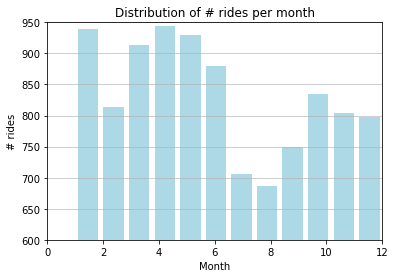

In [25]:
plt.hist(x.month, bins=12, rwidth=0.8, color = 'lightblue')
plt.grid(axis='y', alpha=0.75)
plt.xlim([0,12])
plt.ylim([600,950])
plt.title('Distribution of # rides per month')
plt.xlabel('Month')
plt.ylabel( '# rides')
%matplot plt

#### We can observe a clear difference between the month number of rides. 
 ##### So for our model we are going to one and hot encoding months into 3 group :

low month : july, august september. Number of rides under 750

middle month : february, october, november, december Number of rides under 850

hight month : january, march, april, may, june  Number of rides over 850

In [26]:
df11 = df10.withColumn('Low_Months', 
    when((df10.month == 7) | (df10.month == 8) | (df10.month == 9), lit('1'))
    .otherwise(lit('0')))

df11 = df11.withColumn('Middle_Months', 
    when((df11.month == 2) | (df11.month == 10) | (df11.month == 11) | (df11.month == 12) , lit('1'))
    .otherwise(lit('0')))

df11 = df11.withColumn('High_Months', 
    when((df11.month == 1) | (df11.month == 3) | (df11.month == 4) | (df11.month == 5) | (df11.month == 6) , lit('1'))
    .otherwise(lit('0')))
df11 = df11.drop('month')

In [27]:
averageplot = x.groupby('weekday', as_index=False)['fare_amount'].mean()

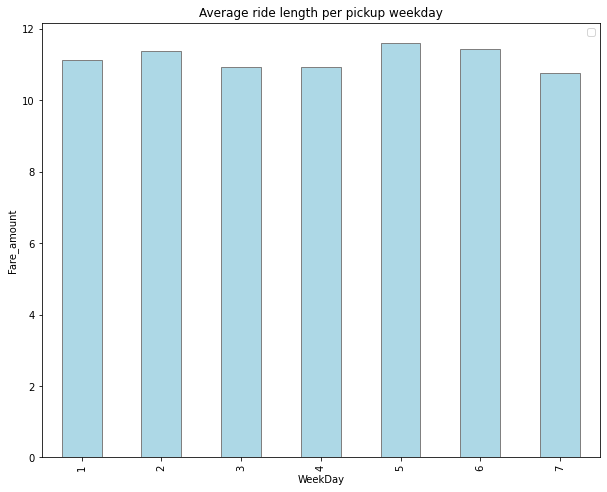

In [28]:
averageplot.plot.bar(x='weekday',y='fare_amount',color='lightblue',edgecolor='grey', figsize =(10,8))
plt.gca().update(dict(title='Average ride length per pickup weekday',
 xlabel= 'WeekDay', ylabel='Fare_amount'))
plt.legend('')
%matplot plt

As we can see, their is no big  difference between the different weekday and so we decided to drop the weekday and the day. 
We will drop as well the year because this is not something we found interesting. The goal is to predict on new trips. New trips will have a later year date. 

In [29]:
df12 = df11.drop('weekday','day','year')

In [30]:
df12.printSchema()

root
 |-- key: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- high_fare: double (nullable = true)
 |-- trip_dist: double (nullable = true)
 |-- zerotofour: string (nullable = false)
 |-- fivetoseven: string (nullable = false)
 |-- eighttoeleven: string (nullable = false)
 |-- twelvetofifteen: string (nullable = false)
 |-- sixteentonineteen: string (nullable = false)
 |-- twentytotthree: string (nullable = false)
 |-- Low_Months: string (nullable = false)
 |-- Middle_Months: string (nullable = false)
 |-- High_Months: string (nullable = false)



In [31]:
df12 = df12.withColumn('zerotofour',df12.zerotofour.cast('double'))
df12 = df12.withColumn('fivetoseven',df12.fivetoseven.cast('double'))

df12 = df12.withColumn('eighttoeleven',df12.eighttoeleven.cast('double'))

df12 = df12.withColumn('twelvetofifteen',df12.twelvetofifteen.cast('double'))

df12 = df12.withColumn('sixteentonineteen',df12.sixteentonineteen.cast('double'))

df12 = df12.withColumn('twentytotthree',df12.twentytotthree.cast('double'))

df12 = df12.withColumn('Low_Months',df12.Low_Months.cast('double'))

df12 = df12.withColumn('Middle_Months',df12.Middle_Months.cast('double'))

df12 = df12.withColumn('High_Months',df12.High_Months.cast('double'))





## Plotting 

Text(0, 0.5, '# rides')

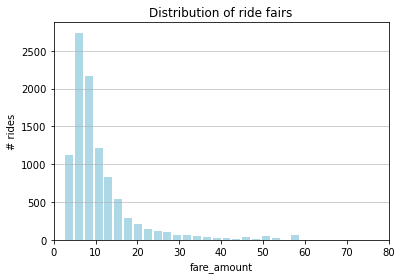

In [32]:
plt.hist(x.fare_amount, bins=50, rwidth=0.8, color = 'lightblue')
plt.grid(axis='y', alpha=0.75)
plt.xlim([0,80])
plt.title('Distribution of ride fairs')
plt.xlabel('fare_amount')
plt.ylabel('# rides')
%matplot plt

Text(0, 0.5, 'trip distance')

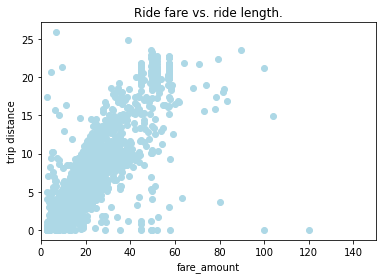

In [33]:
plt.scatter(x.fare_amount, x.trip_dist, color='lightblue')
plt.xlim([0,150])
plt.title('Ride fare vs. ride length.')
plt.xlabel('fare_amount')
plt.ylabel('trip distance')
%matplot plt

In [34]:
averageplot = x.groupby('hour', as_index=False)['trip_dist'].mean()

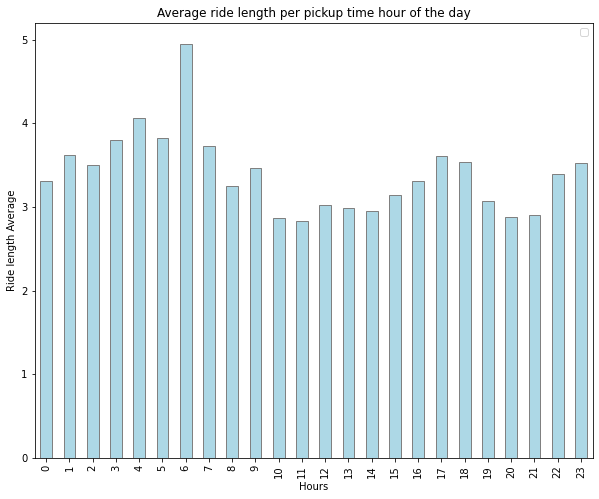

In [36]:
averageplot.plot.bar(x='hour',y='trip_dist',color='lightblue',edgecolor='grey', figsize =(10,8))
plt.gca().update(dict(title='Average ride length per pickup time hour of the day',
 xlabel= 'Hours', ylabel='Ride length Average'))
plt.legend('')
%matplot plt

# Modelling 
### We are going to represent the data into two columns like spark is expecting : feature and label (high fare)
#### At this point we are going to train the model only on 2million rows, on a data that was already cleaned (to avoid any emr crash we runned separatly preprocess and modelling, both on the EMR) 

In [84]:
rows_wanted = 200000
samp_size = rows_wanted*10/df12.count()
modelling_df=df12.sample(False,samp_size,1)
modelling_df.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

1998961

In [4]:
clean_data.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

1999963

In [4]:
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
                                         'passenger_count', 'trip_dist','zerotofour','fivetoseven','eighttoeleven',
                                         'twelvetofifteen','sixteentonineteen','twentytotthree','Low_Months','Middle_Months','High_Months'], outputCol='Features')
model_data = assembler.transform(clean_data)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
model_data.select('Features','high_fare').show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+---------+
|            Features|high_fare|
+--------------------+---------+
|(15,[0,1,2,3,4,5,...|      0.0|
|(15,[0,1,2,3,4,5,...|      1.0|
|(15,[0,1,2,3,4,5,...|      0.0|
|(15,[0,1,2,3,4,5,...|      0.0|
|(15,[0,1,2,3,4,5,...|      0.0|
+--------------------+---------+
only showing top 5 rows

### Splitting the data into 80% Train & 20% Cross validation 

In [6]:
(trainingData, testData) = model_data.randomSplit([0.8, 0.2])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Training the models on 2 millions rows
### Logistic regression with 2 million rows

In [14]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import HashingTF, Tokenizer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import LogisticRegression
evaluator = BinaryClassificationEvaluator(labelCol='high_fare', metricName='areaUnderROC')


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Logistic regression with grid search and crossval

In [8]:
#%%time
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import HashingTF, Tokenizer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import LogisticRegression

evaluator = BinaryClassificationEvaluator(labelCol='high_fare', metricName='areaUnderROC')
algo = LogisticRegression(featuresCol='Features', labelCol='high_fare')


paramGrid = ParamGridBuilder() \
    .addGrid(algo.maxIter, [5, 10, 15]) \
    .addGrid(algo.regParam, [0.3, 0.5]) \
    .addGrid(algo.elasticNetParam, [0.5, 0.6, 0.8]) \
    .build()

cross_val = CrossValidator(estimator=algo,
                           estimatorParamMaps=paramGrid,
                           evaluator=evaluator,
                           numFolds=3)
lrModel = cross_val.fit(trainingData)

predictions = lrModel.transform(testData)
# predictions.select(['high_fare','prediction', 'probability']).show()

evaluator = BinaryClassificationEvaluator(labelCol='high_fare', metricName='areaUnderROC')

accuracy = evaluator.evaluate(predictions)

print('Accuracy:', accuracy)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Accuracy: 0.9259473987890336

## Decision Tree with grid search & crossvalidation

In [15]:
#%%time

from pyspark.ml.classification import DecisionTreeClassifier
algo1 = DecisionTreeClassifier(featuresCol='Features', labelCol='high_fare')

paramGrid = ParamGridBuilder() \
    .addGrid(algo1.maxDepth, [2, 5, 10, 15]) \
    .addGrid(algo1.maxBins, [5, 10]) \
    .addGrid(algo1.impurity, ['entropy','gini']) \
    .build()

cross_valdt = CrossValidator(estimator=algo1,
                           estimatorParamMaps=paramGrid,
                           evaluator=evaluator,
                           numFolds=3)

dtModel = cross_valdt.fit(trainingData)
predictions1 = dtModel.transform(testData)


accuracy1 = evaluator.evaluate(predictions1)

print('Accuracy:', accuracy1)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Accuracy: 0.8783053195123666

## Decision Tree with With maxDepth 10 and maxbins 10 

In [16]:
#%%time

from pyspark.ml.classification import DecisionTreeClassifier
algo2 = DecisionTreeClassifier(featuresCol='Features', labelCol='high_fare', maxDepth=10, maxBins = 10)
dtModel = algo2.fit(trainingData)
predictions2 = dtModel.transform(testData)

accuracy2 = evaluator.evaluate(predictions2)

print('Accuracy:', accuracy2)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Accuracy: 0.8007287005295289

## Random forest with grid search

In [17]:
#%%time
from pyspark.ml.classification import RandomForestClassifier
algo3 = RandomForestClassifier(featuresCol='Features', labelCol='high_fare')


paramGrid = ParamGridBuilder() \
    .addGrid(algo3.maxDepth, [5, 10, 15]) \
    .addGrid(algo3.numTrees, [10, 15, 20]) \
    .addGrid(algo3.impurity, ['entropy','gini']) \
    .build()

cross_valdt = CrossValidator(estimator=algo3,
                           estimatorParamMaps=paramGrid,
                           evaluator=evaluator,
                           numFolds=3)



rfcModel = cross_valdt.fit(trainingData)
predictions3 = rfcModel.transform(testData)
accuracy3 = evaluator.evaluate(predictions3)

print('Accuracy', accuracy3)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Accuracy 0.9403344794001313

# Random forest without crossval

In [18]:
#%%time
from pyspark.ml.classification import RandomForestClassifier
algo4 = RandomForestClassifier(featuresCol='Features', labelCol='high_fare', numTrees=10, maxDepth=5)
rfModel = algo4.fit(trainingData)
predictions4 = rfModel.transform(testData)

accuracy4 = evaluator.evaluate(predictions4)

print('Accuracy', accuracy4)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Accuracy 0.8884494687411428

## Gradient boosting tree with pipeline and indexer

In [19]:
#%%time
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Index labels, adding metadata to the label column.
# Fit on whole dataset to include all labels in index.
# Automatically identify categorical features, and index them.
labelIndexer = StringIndexer(inputCol="high_fare", outputCol="indexedLabel").fit(model_data)
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =\
    VectorIndexer(inputCol="Features", outputCol="indexedFeatures", maxCategories=4).fit(model_data)

gbt = GBTClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", maxIter=10)


# Chain indexers and GBT in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, gbt])

# Train model.  This also runs the indexers.
modelgbt = pipeline.fit(trainingData)

# Make predictions.
predictions5 = modelgbt.transform(testData)

accuracy5 = evaluator.evaluate(predictions5)

print('Accuracy', accuracy5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Accuracy 0.9352387699718184

## Selecting the best model 

We will select the random forest model with grid search, it perform the best

## Final function (For kaggle purpose, no need to run it) 

In [ ]:
# test_set.printSchema()

root
 |-- key: integer (nullable = true)
 |-- pickup_datetime: string (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- passenger_count: integer (nullable = true)



In [68]:
# testData1 = test_set.withColumn('pickup_date_time', F.to_timestamp(test_set.pickup_datetime))
# from math import cos, asin, sqrt, pi
# #Creating a distance function based on coordinates
# def distance(lat1, lon1, lat2, lon2):
#     p = pi/180
#     a = 0.5 - cos((lat2-lat1)*p)/2 + cos(lat1*p) * cos(lat2*p) * (1-cos((lon2-lon1)*p))/2
#     return 12742 * asin(sqrt(a)) #2*R*asin...

# my_udf = F.udf(distance)

# testData1 = testData1.withColumn('trip_dist', my_udf('pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude'))

# #Changing the type of trip_dist to double (forgot to do it before)
# testData1 = testData1.withColumn('trip_dist',testData1.trip_dist.cast('double'))

# testData1 = testData1.withColumn("pickup_date_time",to_timestamp("pickup_date_time")).withColumn("year",
#   year(col("pickup_date_time"))
# ).withColumn(
#   "month",
#   month(col("pickup_date_time"))
# ).withColumn(
#   "day",
#   dayofmonth(col("pickup_date_time"))
# ).withColumn("hour",
#   hour(col("pickup_date_time"))
# ).withColumn("weekday",
#   dayofweek(col("pickup_date_time"))
# )


# ### One hot encoding for week day 

# testData1 = testData1.withColumn('zerotofour', 
#     when((testData1.hour <= 4), lit('1'))
#     .otherwise(lit('0')))

# testData1 = testData1.withColumn('fivetoseven', 
#     F.when((testData1.hour > 4) & (testData1.hour <=7), lit('1'))
#     .otherwise(lit('0')))

# testData1 = testData1.withColumn('eighttoeleven', 
#     F.when((testData1.hour > 8) & (testData1.hour <=11), lit('1'))
#     .otherwise(lit('0')))
    
# testData1 = testData1.withColumn('twelvetofifteen', 
#     F.when((testData1.hour > 12) & (testData1.hour <=15), lit('1'))
#     .otherwise(lit('0')))

# testData1 = testData1.withColumn('sixteentonineteen', 
#     F.when((testData1.hour > 16) & (testData1.hour <=19), lit('1'))
#     .otherwise(lit('0')))

# testData1 = testData1.withColumn('twentytotthree', 
#     F.when((testData1.hour > 20) & (testData1.hour <=23), lit('1'))
#     .otherwise(lit('0')))

#     # One hot encoding for months    
# testData1 = testData1.withColumn('Low_Months', 
#     when((testData1.month == 7) | (testData1.month == 8) | (testData1.month == 9), lit('1'))
#     .otherwise(lit('0')))

# testData1 = testData1.withColumn('Middle_Months', 
#     when((testData1.month == 2) | (testData1.month == 10) | (testData1.month == 11) | (testData1.month == 12) , lit('1'))
#     .otherwise(lit('0')))

# testData1 = testData1.withColumn('High_Months', 
#     when((testData1.month == 1) | (testData1.month == 3) | (testData1.month == 4) | (testData1.month == 5) | (testData1.month == 6) , lit('1'))
#     .otherwise(lit('0')))

# testData1 = testData1.withColumn('zerotofour',testData1.zerotofour.cast('double'))
# testData1 = testData1.withColumn('fivetoseven',testData1.fivetoseven.cast('double'))

# testData1 = testData1.withColumn('eighttoeleven',testData1.eighttoeleven.cast('double'))

# testData1 = testData1.withColumn('twelvetofifteen',testData1.twelvetofifteen.cast('double'))

# testData1 = testData1.withColumn('sixteentonineteen',testData1.sixteentonineteen.cast('double'))

# testData1 = testData1.withColumn('twentytotthree',testData1.twentytotthree.cast('double'))

# testData1 = testData1.withColumn('Low_Months',testData1.Low_Months.cast('double'))

# testData1 = testData1.withColumn('Middle_Months',testData1.Middle_Months.cast('double'))

# testData1 = testData1.withColumn('High_Months',testData1.High_Months.cast('double'))

# testData1 = testData1.drop('pickup_datetime')

# from pyspark.ml.feature import VectorAssembler
# assembler = VectorAssembler(inputCols=['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
#                                          'passenger_count', 'trip_dist','zerotofour','fivetoseven','eighttoeleven',
#                                          'twelvetofifteen','sixteentonineteen','twentytotthree','Low_Months','Middle_Months','High_Months'], outputCol='Features')
# testkaggle = assembler.transform(testData1)



In [ ]:
# # Predictions on test set 
# predictionRFC = rfcModel.transform(testkaggle)

# predictionRFC.select('key','rawPrediction').show()
# to_print_kaggle = predictionRFC.withColumnRenamed('prediction','high_fare')
# to_print_kaggle = to_print_kaggle.select('key','high_fare')
# to_print_kaggle.toPandas().to_csv('random_forest_clf_k11.csv')

In [ ]:
# predictionGBT = modelgbt.transform(testkaggle)

# to_print_kaggle1 = predictionGBT.withColumnRenamed('prediction','high_fare')
# to_print_kaggle1 = to_print_kaggle1.select('key','high_fare')
# to_print_kaggle1.toPandas().to_csv('gradient_boost_kag1.csv')

22/02/08 13:58:38 WARN StringIndexerModel: Input column high_fare does not exist during transformation. Skip StringIndexerModel for this column.


In [69]:
# resultMPC_kaggle = modelMPC.transform(testkaggle)

In [76]:
# to_res_kag = resultMPC_kaggle.withColumnRenamed('prediction','high_fare')

In [77]:
# to_res_kag = to_res_kag.select('key','high_fare')

DataFrame[key: int, high_fare: double]

In [ ]:
# to_res_kag.toPandas()

In [ ]:
# resultMPC_kaggle = modelMPC.transform(testkaggle)
# to_print_kaggle3 = resultMPC_kaggle.withColumnRenamed('prediction','high_fare')
# to_print_kaggle3 = to_print_kaggle3.select('key','high_fare')
# to_print_kaggle3.toPandas().to_csv('MPC_K1.csv')